In [118]:
! pip install kaggle

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [121]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [122]:
!chmod 600 ~/.kaggle/kaggle.json

In [123]:
!kaggle datasets download iamsouravbanerjee/heart-attack-prediction-dataset

heart-attack-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [124]:
!unzip heart-attack-prediction-dataset.zip


Archive:  heart-attack-prediction-dataset.zip
replace heart_attack_prediction_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: heart_attack_prediction_dataset.csv  


In [125]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import chardet
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [126]:
HEART_PATH = os.path.join("/content")
print(HEART_PATH)
def load_heart_data(heart_path = HEART_PATH):
  csv_path = os.path.join(heart_path, 'heart_attack_prediction_dataset.csv')
  print(csv_path)
  #comprobamos el encoding de nuestro dataset para evitar errores
  with open(csv_path, 'rb') as f:
    result = chardet.detect(f.read())
  return pd.read_csv(csv_path, encoding=result['encoding'])

heart_data = load_heart_data(HEART_PATH)
heart_data_copy = heart_data
heart_data.head()

/content
/content/heart_attack_prediction_dataset.csv


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [127]:
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(heart_data, 0.2)

print(len(train_set))
print(len(test_set))

7011
1752


In [128]:
train_set, test_set = train_test_split(heart_data, test_size=0.2, random_state=42)

In [129]:
heart_data["sedentary_cat"] = pd.cut(heart_data["Sedentary Hours Per Day"],
                                     bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                     labels=[1,2,3,4,5])

print(heart_data["sedentary_cat"])

0       5
1       4
2       5
3       5
4       2
       ..
8758    5
8759    3
8760    2
8761    1
8762    5
Name: sedentary_cat, Length: 8763, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


In [130]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(heart_data, heart_data["sedentary_cat"]):
  strat_train_set = heart_data.loc[train_index]
  strat_test_set = heart_data.loc[test_index]

In [131]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("sedentary_cat", axis=1, inplace=True)

In [132]:
heart_data = strat_train_set.copy()

<ipython-input-133-626012aa74ed>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = heart_data.corr()


array([[<Axes: xlabel='Heart Attack Risk', ylabel='Heart Attack Risk'>,
        <Axes: xlabel='Cholesterol', ylabel='Heart Attack Risk'>,
        <Axes: xlabel='Exercise Hours Per Week', ylabel='Heart Attack Risk'>,
        <Axes: xlabel='Income', ylabel='Heart Attack Risk'>],
       [<Axes: xlabel='Heart Attack Risk', ylabel='Cholesterol'>,
        <Axes: xlabel='Cholesterol', ylabel='Cholesterol'>,
        <Axes: xlabel='Exercise Hours Per Week', ylabel='Cholesterol'>,
        <Axes: xlabel='Income', ylabel='Cholesterol'>],
       [<Axes: xlabel='Heart Attack Risk', ylabel='Exercise Hours Per Week'>,
        <Axes: xlabel='Cholesterol', ylabel='Exercise Hours Per Week'>,
        <Axes: xlabel='Exercise Hours Per Week', ylabel='Exercise Hours Per Week'>,
        <Axes: xlabel='Income', ylabel='Exercise Hours Per Week'>],
       [<Axes: xlabel='Heart Attack Risk', ylabel='Income'>,
        <Axes: xlabel='Cholesterol', ylabel='Income'>,
        <Axes: xlabel='Exercise Hours Per Week', y

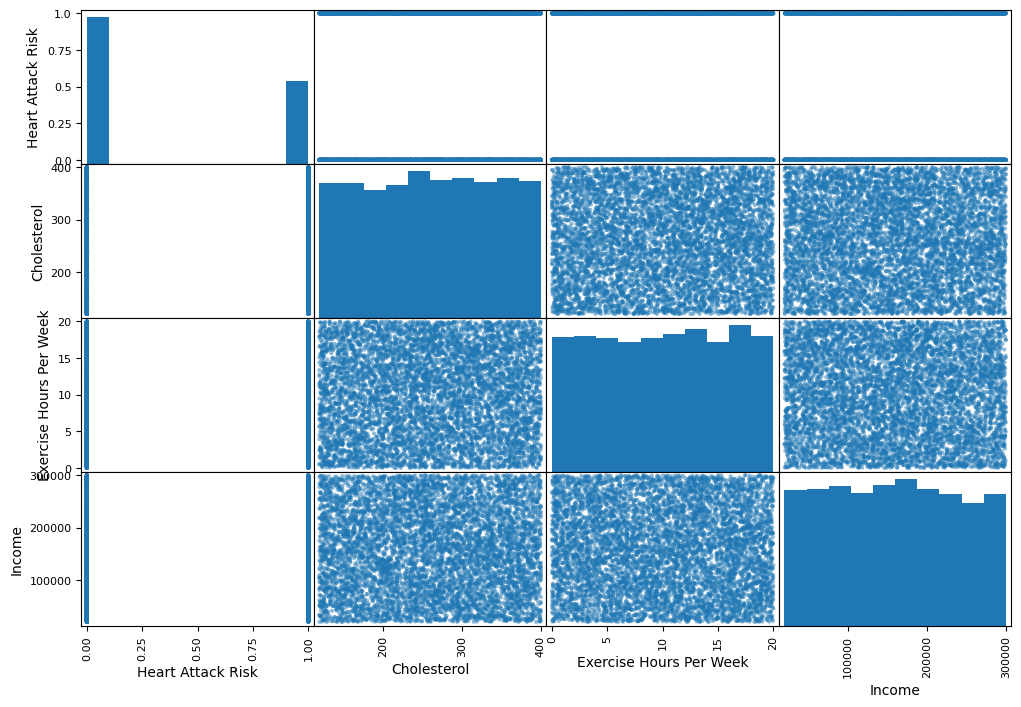

In [133]:
corr_matrix = heart_data.corr()
corr_matrix["Heart Attack Risk"].sort_values(ascending=False)

attributes = ["Heart Attack Risk", "Cholesterol", "Exercise Hours Per Week", "Income"]
scatter_matrix(heart_data[attributes], figsize=(12, 8))

In [134]:
heart_data['Cholesterol_BMI_Ratio'] = heart_data['Cholesterol'] / heart_data['BMI']
heart_data['Exercise_per_week'] = heart_data['Exercise Hours Per Week'] / heart_data['Physical Activity Days Per Week']
heart_data['Diabetes_n_triglycerides'] = heart_data['Diabetes']/heart_data['Triglycerides']

In [135]:
corr_matrix = heart_data.corr()
corr_matrix['Heart Attack Risk'].sort_values(ascending=False)

<ipython-input-135-d1f51c6d7f51>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = heart_data.corr()


Heart Attack Risk                  1.000000
Cholesterol                        0.021491
Exercise Hours Per Week            0.016827
Income                             0.014239
Diabetes                           0.010295
Diabetes_n_triglycerides           0.007341
Cholesterol_BMI_Ratio              0.007125
BMI                                0.006942
Triglycerides                      0.002524
Physical Activity Days Per Week    0.001232
Age                                0.000819
Previous Heart Problems           -0.000981
Smoking                           -0.002381
Family History                    -0.002777
Stress Level                      -0.003676
Medication Use                    -0.004781
Exercise_per_week                 -0.007022
Heart Rate                        -0.009279
Obesity                           -0.012036
Alcohol Consumption               -0.012070
Sedentary Hours Per Day           -0.017920
Sleep Hours Per Day               -0.029453
Name: Heart Attack Risk, dtype: 

In [136]:
heart_data.dtypes

Patient ID                          object
Age                                  int64
Sex                                 object
Cholesterol                          int64
Blood Pressure                      object
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Diet                                object
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Country                             object
Continent  

In [137]:
heart_data = strat_train_set.drop("Heart Attack Risk", axis=1)
heart_data_labels = strat_train_set["Heart Attack Risk"].copy()
imputer = SimpleImputer(strategy="median")
heart_data_num = heart_data.drop(['Patient ID', 'Sex', 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere'], axis = 1)
imputer.fit(heart_data_num)
X = imputer.transform(heart_data_num)

In [138]:
imputer.statistics_

array([5.40000000e+01, 2.61000000e+02, 7.50000000e+01, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.01965762e+01, 0.00000000e+00, 0.00000000e+00, 5.00000000e+00,
       5.93574113e+00, 1.58284500e+05, 2.87741847e+01, 4.16000000e+02,
       3.00000000e+00, 7.00000000e+00])

In [139]:

heart_data_tr = pd.DataFrame(X, columns=heart_data_num.columns,
                             index=heart_data_num.index)

In [140]:
heart_data_cat = heart_data.select_dtypes(include=['object'])
heart_data_cat.head(10)


,Patient ID,Sex,Blood Pressure,Diet,Country,Continent,Hemisphere
4407,UWX3861,Male,90/61,Unhealthy,United Kingdom,Europe,Northern Hemisphere
7517,LGS3961,Female,129/65,Unhealthy,China,Asia,Northern Hemisphere
4365,KZJ3624,Male,98/85,Healthy,Colombia,South America,Northern Hemisphere
2385,UOY1703,Male,174/93,Healthy,United Kingdom,Europe,Northern Hemisphere
4591,ACY3251,Male,150/83,Average,Spain,Europe,Southern Hemisphere
4981,LBH2023,Male,136/88,Unhealthy,China,Asia,Northern Hemisphere
4439,SIU2151,Female,174/68,Healthy,Italy,Europe,Southern Hemisphere
4838,MSP0640,Male,145/99,Unhealthy,Nigeria,Africa,Northern Hemisphere
6531,VRS2034,Female,136/93,Healthy,Thailand,Asia,Northern Hemisphere
222,IAB5092,Male,102/105,Healthy,South Africa,Africa,Southern Hemisphere


In [141]:
ordinal_encoder = OrdinalEncoder()
heart_data_encoded = ordinal_encoder.fit_transform(heart_data_cat)
heart_data_encoded[:10]

array([[5.578e+03, 1.000e+00, 3.204e+03, 2.000e+00, 1.700e+01, 3.000e+00,
        0.000e+00],
       [3.006e+03, 0.000e+00, 1.172e+03, 2.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00],
       [2.929e+03, 1.000e+00, 3.520e+03, 1.000e+00, 5.000e+00, 5.000e+00,
        0.000e+00],
       [5.488e+03, 1.000e+00, 2.955e+03, 1.000e+00, 1.700e+01, 3.000e+00,
        0.000e+00],
       [3.100e+01, 1.000e+00, 1.989e+03, 0.000e+00, 1.500e+01, 3.000e+00,
        1.000e+00],
       [2.945e+03, 1.000e+00, 1.461e+03, 2.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00],
       [4.896e+03, 0.000e+00, 2.937e+03, 1.000e+00, 9.000e+00, 3.000e+00,
        1.000e+00],
       [3.388e+03, 1.000e+00, 1.818e+03, 2.000e+00, 1.200e+01, 0.000e+00,
        0.000e+00],
       [5.785e+03, 0.000e+00, 1.463e+03, 1.000e+00, 1.600e+01, 1.000e+00,
        0.000e+00],
       [2.139e+03, 1.000e+00, 9.000e+01, 1.000e+00, 1.300e+01, 0.000e+00,
        1.000e+00]])

In [142]:
ordinal_encoder.categories_

[array(['AAA9246', 'AAC3641', 'AAD0466', ..., 'ZZQ4895', 'ZZT7113',
        'ZZY4724'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['100/100', '100/103', '100/104', ..., '99/94', '99/96', '99/98'],
       dtype=object),
 array(['Average', 'Healthy', 'Unhealthy'], dtype=object),
 array(['Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'Colombia',
        'France', 'Germany', 'India', 'Italy', 'Japan', 'New Zealand',
        'Nigeria', 'South Africa', 'South Korea', 'Spain', 'Thailand',
        'United Kingdom', 'United States', 'Vietnam'], dtype=object),
 array(['Africa', 'Asia', 'Australia', 'Europe', 'North America',
        'South America'], dtype=object),
 array(['Northern Hemisphere', 'Southern Hemisphere'], dtype=object)]

In [143]:
cat_encoder = OneHotEncoder()
heart_data_cat_1hot = cat_encoder.fit_transform(heart_data_cat)
heart_data_cat_1hot

<7010x10612 sparse matrix of type '<class 'numpy.float64'>'
	with 49070 stored elements in Compressed Sparse Row format>

In [144]:
heart_data_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [145]:
heart_data.columns

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere'],
      dtype='object')

In [146]:
from sklearn.base import TransformerMixin, BaseEstimator
cholesterol_ix = heart_data_num.columns.get_loc('Cholesterol')
bmi_ix = heart_data_num.columns.get_loc('BMI')
diabetes_ix = heart_data_num.columns.get_loc('Diabetes')
tryglicerides_ix = heart_data_num.columns.get_loc('Triglycerides')
print(cholesterol_ix, bmi_ix, diabetes_ix, tryglicerides_ix)

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_cholesterol_and_tryg = True):
    self.add_cholesterol_and_tryg = add_cholesterol_and_tryg
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    diabetes_n_triglycerides = (X[:, diabetes_ix] + 1e-10) / X[:, tryglicerides_ix]
    cholesterol_bmi_ratio = (X[:, cholesterol_ix] + 1e-10) / (X[:, bmi_ix] +1e-10)
    if self.add_cholesterol_and_tryg:
      cholesterol_and_tryg = (X[:, cholesterol_ix] + 1e-10) / (X[:, tryglicerides_ix]+1e-10)
      return np.c_[X, diabetes_n_triglycerides, cholesterol_bmi_ratio, cholesterol_and_tryg]
    else:
      return np.c_[X, diabetes_n_triglycerides, cholesterol_bmi_ratio]



1 14 3 15


In [147]:
attr_adder = CombinedAttributesAdder(add_cholesterol_and_tryg=False)
heart_data_extra_attribs = attr_adder.transform(heart_data.values)

In [148]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

heart_data_num = heart_data_num.replace([np.inf, -np.inf], np.nan)
heart_data_num = heart_data_num.fillna(heart_data_num.mean())
heart_data_num_tr = num_pipeline.fit_transform(heart_data_num)

In [149]:
import joblib
num_attribs = list(heart_data_num)
cat_attribs = ["Patient ID","Sex","Blood Pressure","Diet","Country","Continent", "Hemisphere"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
])

# Ahora deberías poder ajustar el pipeline sin errores
heart_data_prepared = full_pipeline.fit_transform(heart_data)
heart_data_prepared.shape
joblib.dump(full_pipeline, "full_pipeline.pkl")

['full_pipeline.pkl']

In [150]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(heart_data_prepared, heart_data_labels)

LinearRegression()

In [151]:
some_data = heart_data.iloc[:5]
some_labels = heart_data_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions", lin_reg.predict(some_data_prepared))

Predictions [ 3.08241579e-05  1.00008511e+00  9.99883279e-01  9.99906454e-01
 -2.89168244e-05]


In [152]:
print("LABELS: ", list(some_labels))

LABELS:  [0, 1, 1, 1, 0]


In [153]:
from sklearn.metrics import mean_squared_error
heart_data_predictions = lin_reg.predict(heart_data_prepared)
lin_mse = mean_squared_error(heart_data_labels, heart_data_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.00016494991236673203

In [154]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(heart_data_prepared, heart_data_labels)

DecisionTreeRegressor()

In [155]:
heart_data_predictions = tree_reg.predict(heart_data_prepared)
tree_mse = mean_squared_error(heart_data_labels, heart_data_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [156]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, heart_data_prepared, heart_data_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [157]:
def display_scores(scores):
  print("Scores: ", scores)
  print("Mean: ", scores.mean())
  print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [0.66285166 0.69335546 0.66500029 0.68299082 0.70356743 0.67669584
 0.65418656 0.65961559 0.69129497 0.67880065]
Mean:  0.6768359284685863
Standard deviation:  0.015438492373377402


In [158]:
lin_scores = cross_val_score(lin_reg, heart_data_prepared, heart_data_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [0.5225107  0.52180166 0.51158804 0.5304613  0.52508451 0.51844739
 0.51895766 0.52541592 0.52194489 0.52371228]
Mean:  0.521992434072452
Standard deviation:  0.0047570641430248976


In [159]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(heart_data_prepared, heart_data_labels)
heart_data_predictions = forest_reg.predict(heart_data_prepared)
forest_mse = mean_squared_error(heart_data_labels, heart_data_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.18248217234559042

In [160]:
forest_scores = cross_val_score(forest_reg, heart_data_prepared, heart_data_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [0.49638019 0.48181747 0.49069051 0.48628068 0.4815453  0.49056796
 0.4885451  0.49148716 0.48707781 0.48536543]
Mean:  0.48797576150954747
Standard deviation:  0.004326045197605481


In [161]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(heart_data_prepared, heart_data_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [162]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [163]:

final_model = grid_search.best_estimator_

x_test = strat_test_set.drop("Heart Attack Risk", axis=1)
y_test = strat_test_set["Heart Attack Risk"].copy

In [164]:

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)
y_test = y_test()
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

joblib.dump(final_model, 'random_forest_model.pkl')

0.48427906111917923


['random_forest_model.pkl']

In [165]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import numpy as np
from joblib import dump

# Preparar los datos
x_test_prepared = full_pipeline.transform(x_test)

# Entrenar el modelo SVC
svc_model = SVC()
svc_model.fit(heart_data_prepared, heart_data_labels)

# Hacer predicciones con el modelo SVC
svc_predictions = svc_model.predict(x_test_prepared)

# Calcular el error cuadrático medio para el modelo SVC
svc_mse = mean_squared_error(y_test, svc_predictions)
svc_rmse = np.sqrt(svc_mse)
print(svc_rmse)

# Guardar el modelo SVC
dump(svc_model, 'svc_model.pkl')

# Entrenar el modelo DT
dt_model = DecisionTreeClassifier()
dt_model.fit(heart_data_prepared, heart_data_labels)

# Hacer predicciones con el modelo DT
dt_predictions = dt_model.predict(x_test_prepared)

# Calcular el error cuadrático medio para el modelo DT
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
print(dt_rmse)

# Guardar el modelo DT
dump(dt_model, 'dt_model.pkl')

0.5913427535187947
0.6713091823105215


['dt_model.pkl']

In [166]:
from sklearn.ensemble import RandomForestClassifier

In [167]:
# Preparar los datos
x_test_prepared = full_pipeline.transform(x_test)

# Entrenar el modelo RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(heart_data_prepared, heart_data_labels)

# Hacer predicciones con el modelo RandomForestClassifier
rf_predictions = rf_model.predict(x_test_prepared)

# Calcular el error cuadrático medio para el modelo RandomForestClassifier
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)

# Guardar el modelo RandomForestClassifier
dump(rf_model, 'random_forest_model.pkl')

0.5903772953181325


['random_forest_model.pkl']